<a href="https://colab.research.google.com/github/B21-CAP0075/Dementia-Classification/blob/development/Dementia_CDR_Classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import zipfile
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from google.colab import drive
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler 
from sklearn.model_selection import train_test_split

import tensorflow as tf
from keras.models import load_model
from keras.callbacks import EarlyStopping
from keras.callbacks import ModelCheckpoint

In [2]:
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
! pip install --upgrade --force-reinstall --no-deps kaggle
! mkdir /root/.kaggle/
! cp "/content/drive/My Drive/Machine Learning/kaggle.json" /root/.kaggle/
! chmod 600 /root/.kaggle/kaggle.json

     |████████████████████████████████| 61kB 9.3MB/s 
  Created wheel for kaggle: filename=kaggle-1.5.12-cp37-none-any.whl size=73053 sha256=65fb0a8ddb0483e731d683f485c414db762dde72fcf54da43f8c189fbe75e9bf
  Stored in directory: /root/.cache/pip/wheels/a1/6a/26/d30b7499ff85a4a4593377a87ecf55f7d08af42f0de9b60303
Successfully built kaggle
  Found existing installation: kaggle 1.5.12
    Uninstalling kaggle-1.5.12:
      Successfully uninstalled kaggle-1.5.12


In [4]:
! kaggle datasets download -d jboysen/mri-and-alzheimers

  0% 0.00/12.6k [00:00<?, ?B/s]
100% 12.6k/12.6k [00:00<00:00, 12.3MB/s]


In [5]:
zip_ref = zipfile.ZipFile('mri-and-alzheimers.zip', 'r')
zip_ref.extractall()
zip_ref.close()

In [142]:
df_cross = pd.read_csv('oasis_cross-sectional.csv')
df_cross.head()

,ID,M/F,Hand,Age,Educ,SES,MMSE,CDR,eTIV,nWBV,ASF,Delay
0,OAS1_0001_MR1,F,R,74,2.0,3.0,29.0,0.0,1344,0.743,1.306,NaN
1,OAS1_0002_MR1,F,R,55,4.0,1.0,29.0,0.0,1147,0.810,1.531,NaN
2,OAS1_0003_MR1,F,R,73,4.0,3.0,27.0,0.5,1454,0.708,1.207,NaN
3,OAS1_0004_MR1,M,R,28,NaN,NaN,NaN,NaN,1588,0.803,1.105,NaN
4,OAS1_0005_MR1,M,R,18,NaN,NaN,NaN,NaN,1737,0.848,1.010,NaN


In [143]:
df_long = pd.read_csv('oasis_longitudinal.csv')
df_long.head()

,Subject ID,MRI ID,Group,Visit,MR Delay,M/F,Hand,Age,EDUC,SES,MMSE,CDR,eTIV,nWBV,ASF
0,OAS2_0001,OAS2_0001_MR1,Nondemented,1,0,M,R,87,14,2.0,27.0,0.0,1987,0.696,0.883
1,OAS2_0001,OAS2_0001_MR2,Nondemented,2,457,M,R,88,14,2.0,30.0,0.0,2004,0.681,0.876
2,OAS2_0002,OAS2_0002_MR1,Demented,1,0,M,R,75,12,NaN,23.0,0.5,1678,0.736,1.046
3,OAS2_0002,OAS2_0002_MR2,Demented,2,560,M,R,76,12,NaN,28.0,0.5,1738,0.713,1.010
4,OAS2_0002,OAS2_0002_MR3,Demented,3,1895,M,R,80,12,NaN,22.0,0.5,1698,0.701,1.034


In [144]:
df_cross = df_cross.drop(columns=['ID', 'Delay', 'Hand', 'eTIV', 'nWBV', 'ASF'])
df_cross.columns = ['M/F', 'Age',	'EDUC',	'SES',	'MMSE',	'CDR']
df_cross.head()

,M/F,Age,EDUC,SES,MMSE,CDR
0,F,74,2.0,3.0,29.0,0.0
1,F,55,4.0,1.0,29.0,0.0
2,F,73,4.0,3.0,27.0,0.5
3,M,28,NaN,NaN,NaN,NaN
4,M,18,NaN,NaN,NaN,NaN


In [145]:
df_long = df_long.drop(columns=['Subject ID', 'MRI ID', 'Visit', 'MR Delay', 'Hand', 'eTIV', 'nWBV', 'ASF', 'Group'])
df_long.head()

,M/F,Age,EDUC,SES,MMSE,CDR
0,M,87,14,2.0,27.0,0.0
1,M,88,14,2.0,30.0,0.0
2,M,75,12,NaN,23.0,0.5
3,M,76,12,NaN,28.0,0.5
4,M,80,12,NaN,22.0,0.5


In [190]:
df = pd.concat([df_cross, df_long])
df = df[df['CDR'].notna()]
df

,M/F,Age,EDUC,SES,MMSE,CDR
0,F,74,2.0,3.0,29.0,0.0
1,F,55,4.0,1.0,29.0,0.0
2,F,73,4.0,3.0,27.0,0.5
8,M,74,5.0,2.0,30.0,0.0
9,F,52,3.0,2.0,30.0,0.0
...,...,...,...,...,...,...
368,M,82,16.0,1.0,28.0,0.5
369,M,86,16.0,1.0,26.0,0.5
370,F,61,13.0,2.0,30.0,0.0
371,F,63,13.0,2.0,30.0,0.0


In [191]:
df['CDR'] = df['CDR'].replace(
    [0.0, 0.5, 1.0, 2.0],
    ['normal', 'normal', 'mild', 'moderate']
)

print(df['CDR'].unique())

['normal' 'mild' 'moderate']


/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


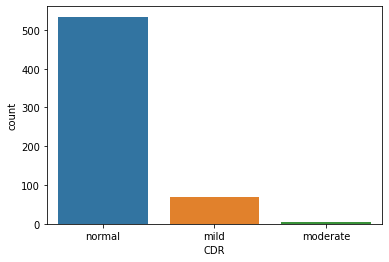

In [193]:
sns.countplot(df['CDR'])

In [194]:
df.isnull().sum()

M/F      0
Age      0
EDUC     0
SES     38
MMSE     2
CDR      0
dtype: int64

In [195]:
df_null = df[df.isnull().any(axis=1)]
df_null.head()

,M/F,Age,EDUC,SES,MMSE,CDR
13,M,76,2.0,NaN,28.0,normal
37,F,62,2.0,NaN,28.0,normal
42,M,64,2.0,NaN,22.0,normal
55,M,79,4.0,NaN,29.0,normal
69,M,43,4.0,NaN,30.0,normal


In [196]:
median_mmse = df['MMSE'].median()
median_ses = df['SES'].median()
print(median_mmse)
print(median_ses)

29.0
2.0


In [197]:
df['MMSE'].fillna(median_mmse, inplace=True)
df['SES'].fillna(median_ses, inplace=True)
df.isnull().sum()

M/F     0
Age     0
EDUC    0
SES     0
MMSE    0
CDR     0
dtype: int64

In [198]:
category = pd.get_dummies(df['CDR'])
gender = pd.get_dummies(df['M/F'])

df = df.drop(columns=['M/F', 'CDR'])
df = pd.concat([df, gender, category], axis=1)
df

,Age,EDUC,SES,MMSE,F,M,mild,moderate,normal
0,74,2.0,3.0,29.0,1,0,0,0,1
1,55,4.0,1.0,29.0,1,0,0,0,1
2,73,4.0,3.0,27.0,1,0,0,0,1
8,74,5.0,2.0,30.0,0,1,0,0,1
9,52,3.0,2.0,30.0,1,0,0,0,1
...,...,...,...,...,...,...,...,...,...
368,82,16.0,1.0,28.0,0,1,0,0,1
369,86,16.0,1.0,26.0,0,1,0,0,1
370,61,13.0,2.0,30.0,1,0,0,0,1
371,63,13.0,2.0,30.0,1,0,0,0,1


In [321]:
df_normal = df[df['normal'] == 1]
df_mild = df[df['mild'] == 1]
df_moderate = df[df['moderate'] == 1]

print(len(df_normal))
print(len(df_mild))
print(len(df_moderate))

534
69
5


In [322]:
x_normal = df_normal[['Age', 'EDUC', 'SES', 'MMSE', 'F',	'M']].values
y_normal = df_normal[['mild',	'moderate',	'normal']].values

x_mild = df_mild[['Age', 'EDUC', 'SES', 'MMSE', 'F',	'M']].values
y_mild = df_mild[['mild',	'moderate',	'normal']].values

x_moderate = df_moderate[['Age', 'EDUC', 'SES', 'MMSE', 'F',	'M']].values
y_moderate = df_moderate[['mild',	'moderate',	'normal']].values

In [323]:
split = 0.2
x_train_normal, x_test_normal, y_train_normal, y_test_normal = train_test_split(x_normal, y_normal, test_size=split, random_state=42)
x_train_mild, x_test_mild, y_train_mild, y_test_mild = train_test_split(x_mild, y_mild, test_size=split, random_state=42)
x_train_moderate, x_test_moderate, y_train_moderate, y_test_moderate = train_test_split(x_moderate, y_moderate, test_size=split, random_state=42)

print(len(x_test_normal))
print(len(x_test_mild))
print(len(x_test_moderate))

107
14
1


In [348]:
x_train = (x_train_normal, x_train_mild, x_train_moderate)
x_test = (x_test_normal, x_test_mild, x_test_moderate)
y_train = (y_train_normal, y_train_mild, y_train_moderate)
y_test = (y_test_normal, y_test_mild, y_test_moderate)

In [349]:
x_train, x_test, y_train, y_test = np.concatenate(x_train), np.concatenate(x_test), np.concatenate(y_train), np.concatenate(y_test)

In [350]:
print(x_train.shape)
print(x_test.shape)

(486, 6)
(122, 6)


In [351]:
scaler = MinMaxScaler().fit(x_train)
x_train_scaled = scaler.transform(x_train)
x_test_scaled = scaler.transform(x_test)

In [387]:
model = tf.keras.Sequential([
                             tf.keras.layers.Dense(16, activation='relu', input_shape=[6]),
                             tf.keras.layers.Dropout(0.25),
                             tf.keras.layers.Dense(8, activation='relu'),
                             tf.keras.layers.Dropout(0.2),
                             tf.keras.layers.Dense(3, activation='softmax')    
])

model.compile(
    optimizer=tf.keras.optimizers.Adam(),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

model.summary()

Model: "sequential_50"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_153 (Dense)            (None, 16)                112       
_________________________________________________________________
dropout_65 (Dropout)         (None, 16)                0         
_________________________________________________________________
dense_154 (Dense)            (None, 8)                 136       
_________________________________________________________________
dropout_66 (Dropout)         (None, 8)                 0         
_________________________________________________________________
dense_155 (Dense)            (None, 3)                 27        
Total params: 275
Trainable params: 275
Non-trainable params: 0
_________________________________________________________________


In [388]:
class StopTraining(tf.keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs=None):
    accuracy = 0.9
    loss = 0.29
    if(logs.get('accuracy') >= accuracy and logs.get('val_accuracy') >= accuracy and
       logs.get('loss') <= loss and logs.get('val_loss') <= loss):
      print('\nSudah mencapai akurasi {}%, proses training berhenti'.format(accuracy*100))
      self.model.stop_training = True

mc = ModelCheckpoint('best_model.h5', monitor='val_accuracy', save_best_only=True)
es = EarlyStopping(monitor='val_loss', patience=75)
st = StopTraining()

In [389]:
history = model.fit(x_train_scaled, y_train, epochs=500, validation_data=(x_test_scaled, y_test), callbacks=[mc, es, st], verbose=2)

Epoch 1/500
16/16 - 1s - loss: 1.1305 - accuracy: 0.3642 - val_loss: 1.0164 - val_accuracy: 0.7213
Epoch 2/500
16/16 - 0s - loss: 0.9914 - accuracy: 0.6523 - val_loss: 0.9202 - val_accuracy: 0.8770
Epoch 3/500
16/16 - 0s - loss: 0.9173 - accuracy: 0.7140 - val_loss: 0.8477 - val_accuracy: 0.8770
Epoch 4/500
16/16 - 0s - loss: 0.8481 - accuracy: 0.8189 - val_loss: 0.7828 - val_accuracy: 0.8770
Epoch 5/500
16/16 - 0s - loss: 0.7893 - accuracy: 0.8498 - val_loss: 0.7181 - val_accuracy: 0.8770
Epoch 6/500
16/16 - 0s - loss: 0.7454 - accuracy: 0.8601 - val_loss: 0.6573 - val_accuracy: 0.8770
Epoch 7/500
16/16 - 0s - loss: 0.6481 - accuracy: 0.8663 - val_loss: 0.5967 - val_accuracy: 0.8770
Epoch 8/500
16/16 - 0s - loss: 0.6104 - accuracy: 0.8765 - val_loss: 0.5479 - val_accuracy: 0.8770
Epoch 9/500
16/16 - 0s - loss: 0.5703 - accuracy: 0.8786 - val_loss: 0.5016 - val_accuracy: 0.8770
Epoch 10/500
16/16 - 0s - loss: 0.5341 - accuracy: 0.8786 - val_loss: 0.4606 - val_accuracy: 0.8770
Epoch 11/

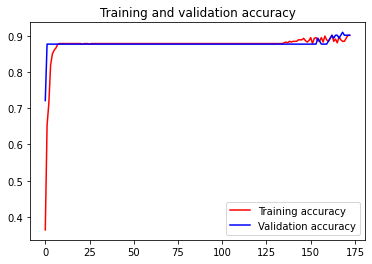

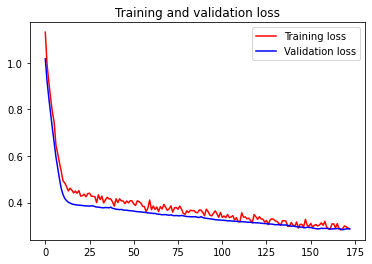

In [390]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(len(acc))

plt.plot(epochs, acc, 'r', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend(loc=0)
plt.figure()

plt.plot(epochs, loss, 'r', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend(loc=0)

plt.show()

In [391]:
saved_model = load_model('best_model.h5')

loss, acc = saved_model.evaluate(x_test_scaled, y_test)
print("Accuracy: ", acc)
print("Loss: ", loss)

4/4 [==============================] - 0s 4ms/step - loss: 0.2834 - accuracy: 0.9098
Accuracy:  0.9098360538482666
Loss:  0.2834383547306061
